# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

Подгружаю необходимые библиотеки и открываю файл с данными.

In [1]:
!pip install -q --upgrade gdown

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from tqdm.notebook import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
!pip list |grep lightgbm

lightgbm                          3.3.1


In [5]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/content/toxic_comments.csv', index_col=0)

df.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Теперь рассмотрю данные представленные в датасете.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [8]:
df.duplicated().sum()

0

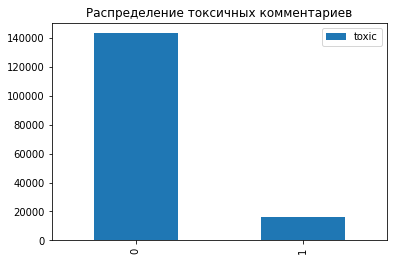

In [9]:
df['toxic'].value_counts().plot(kind='bar', label='toxic')
plt.legend()
plt.title('Распределение токсичных комментариев');
plt.show()

In [10]:
print(f"Процент объектов класса 1 к общему объёму датасета: {(sum(df['toxic']) / len(df) * 100):.2f}%")

Процент объектов класса 1 к общему объёму датасета: 10.16%


По результатам анализа видно, что отсутствуют пропуски в датасете и присутствует дисбаланс классов.

Теперь создам функцию в которой приведу текст к нижнему регистру, очищу текст от лишних символов и лемматизирую его.

In [11]:
stopwords = set(nltk_stopwords.words('english'))

In [12]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
lemmatizer = WordNetLemmatizer()
def lemm_text(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text.lower())
    tokens = nltk.word_tokenize(text)
    text = [word for word in tokens if word not in stopwords]
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens] 
    clean_text = ' '.join(text)
    return clean_text

In [14]:
%%time
df['lemm_text'] = df['text'].progress_apply(lemm_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 17min 30s, sys: 1min 42s, total: 19min 13s
Wall time: 19min 42s


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159292 non-null  object
 1   toxic      159292 non-null  int64 
 2   lemm_text  159292 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.9+ MB


In [19]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Далее разделю датасет на обучающую и тестовую выборки.

In [20]:
features = df.drop('toxic', axis=1)
target = df['toxic']

In [21]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=42, stratify=target)

In [22]:
corpus_train = features_train['lemm_text']
corpus_test = features_test['lemm_text']

**Вывод:**

Проведена подготовка данных перед обучением моделей, в ходе которой было выполнено следующее:
- Подгружены и рассмотрены данные:
    - пропуски в данных отсутствуют;
    - присутствует дисбаланс классов целевого признака.
- Проведена предобработка текста комментариев:
    - текст приведен к нижнему регистру;
    - текст разбит на токены и лемматизирован;
    - текст очищен от символов.
- Датасет разделен на обучающую и тестовую выборку, размер тестовой выборки составляет 10%.
- Выделены корпусы текста для каждой выборки.

## Обучение

Рассмотрю модели логистической регрессии, дерева решений, случайного леса и LightGBM. Для подбора параметров буду использовать RandomizedSearchCV и пайплайн.

In [24]:
model = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'LGBMClassifier']

In [25]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

Напишу функцию для подбора параметров и обучения моделей.

In [26]:
def model_training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    random_model = RandomizedSearchCV(pipeline, param_distributions = params,
                                   cv=cv, scoring = 'f1', n_jobs = -1, random_state = 42, verbose=False)
    random_model.fit(corpus_train, target_train)
    print('Метрика качества F1: ', random_model.best_score_)
    print('Best params: ', random_model.best_params_)
    return random_model

**Логистическая регрессия**

In [27]:
%%time
model_lr = LogisticRegression()
#param_lr = {'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#    'model__max_iter': [1000], 'model__C': [0.1, 1, 5, 10, 15, 20], 'model__class_weight': ['balanced']}
param_lr = {'model__penalty': ['l2'], 'model__class_weight': ['balanced'],
    'model__max_iter': [1000], 'model__C': [10]}
model_lr_f = model_training(model_lr, param_lr)

Метрика качества F1:  0.7717962888152403
Best params:  {'model__penalty': 'l2', 'model__max_iter': 1000, 'model__class_weight': 'balanced', 'model__C': 10}
CPU times: user 5min 46s, sys: 10min 14s, total: 16min
Wall time: 16min 1s


**Дерево решений**

In [28]:
%%time
model_dtc = DecisionTreeClassifier(random_state=42)
#param_dtc = {'model__max_depth': range(5, 41, 4),
#    'model__criterion':['gini','entropy']}
param_dtc = {'model__max_depth': [37],
    'model__criterion':['gini']}
model_dtc_f = model_training(model_dtc, param_dtc)

Метрика качества F1:  0.6948146519233674
Best params:  {'model__max_depth': 37, 'model__criterion': 'gini'}
CPU times: user 3min 46s, sys: 2.27 s, total: 3min 48s
Wall time: 3min 48s


**Случайный лес**

In [29]:
%%time
model_rfc = RandomForestClassifier(random_state=42)
#param_rfc = {'model__max_depth': range(5, 21, 4),
#            'model__n_estimators': [50, 200, 310],
#            'model__min_samples_split': [5, 10, 20]}
param_rfc = {'model__max_depth': [17],
            'model__n_estimators': [50],
             'model__min_samples_split': [5]}
model_rfc_f = model_training(model_rfc, param_rfc)

Метрика качества F1:  0.0005481616033704858
Best params:  {'model__n_estimators': 50, 'model__min_samples_split': 5, 'model__max_depth': 17}
CPU times: user 1min 1s, sys: 1.08 s, total: 1min 2s
Wall time: 1min 2s


**LGBMClassifier**

In [30]:
%%time
model_lgbmc = LGBMClassifier(objective='binary') #
#param_lgbmc = {'model__num_iterations': [500, 1000],
#             'model__max_depth': [10, 18],
#             'model__is_unbalance': [True, False],
#             'model__num_leaves': [5, 10, 15]}
param_lgbmc = {'model__max_depth': [18], 'model__is_unbalance': [False],
               'model__num_leaves': [15], 'model__num_iterations': [500]}
model_lgbmc_f = model_training(model_lgbmc, param_lgbmc)

Метрика качества F1:  0.7813869681757001
Best params:  {'model__num_leaves': 15, 'model__num_iterations': 500, 'model__max_depth': 18, 'model__is_unbalance': False}
CPU times: user 1h 2min 25s, sys: 0 ns, total: 1h 2min 25s
Wall time: 1h 2min 54s


In [31]:
results = pd.DataFrame({'F1_score' : [model_lr_f.best_score_, model_dtc_f.best_score_,
                                      model_rfc_f.best_score_, model_lgbmc_f.best_score_]},
                       index=model).sort_values(by='F1_score', ascending=False)
results

,F1_score
LGBMClassifier,0.781387
LogisticRegression,0.771796
DecisionTreeClassifier,0.694815
RandomForestClassifier,0.000548


Результат со значением метрики качества F1 не меньше 0.75 показали только две модели - LGBMClassifier и LogisticRegression. Но значение у модели LGBMClassifier не много выше, поэтому данную модель признаю лучшей и проверю ее качество на тестовой выборке.

In [32]:
%%time
final_pred = model_lgbmc_f.predict(corpus_test)
print('Значение метрики F1 лучшей модели на тестовой выборке: ', f1_score(target_test, final_pred))

Значение метрики F1 лучшей модели на тестовой выборке:  0.791927627000696
CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.57 s


## Выводы

В ходе выполнения проекта были выполнены основные операции:
- Проведена подготовка данных перед обучением моделей
  - Подгружены и рассмотрены данные.
  - Проведена предобработка текста комментариев.
  - Датасет разделен на обучающую и тестовую выборку, размер тестовой выборки составляет 10%.
  - Выделены корпусы текста для каждой выборки.
- Проведено обучение моделей:
  - LogisticRegression.
  - DecisionTreeClassifier.
  - RandomForestClassifier.
  - LGBMClassifier.
- Рассчитано значение метрики F1 с применением кросс-валидации.
- Найдена лучшая модель и проверена на тестовой выборке. 

Лучше всего себя показала модель LogisticRegression, а хуже всего RandomForestClassifier.

Значение метрики F1 модели на тестовой выборке показало отличный результат, он практически не отличается от значения на обучающей выборке. Модель предсказывает со значением метрики качества F1 не меньше 0.75. Значит модель можно использовать и она подходит по критериям Заказчику.